In [1]:
# imports
import os
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import mudata
from anndata import AnnData
from mudata import MuData
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn3


def get_target_vs_nontarget_expr(
    mdata: MuData,
    guide_id: str,
    gene_id: str,
    guide_mod: str = "guide",
    gene_mod: str = "gene",
    gene_layer: str = None,
    guide_assignment_layer: str = "guide_assignment",
    non_targeting_label: str = "non_targeting",
) -> pd.DataFrame:
    """
    Return a long-format expression DataFrame for a given guide and gene, with
    one row per cell and columns: ["expression", "group"].

    Parameters
    ----------
    mdata
        MuData object with a guide modality and a gene-expression modality.
    guide_id
        The guide identifier (must be a column in guide.var_names).
    gene_id
        The gene identifier (must be a column in gene.var_names).
    guide_mod
        Key for the guide modality in mdata.mod.
    gene_mod
        Key for the gene-expression modality in mdata.mod.
    guide_assignment_layer
        Name of the layer in the guide AnnData containing guide assignments.
    non_targeting_label
        Value in guide.var["label"] that marks non-targeting guides.

    Returns
    -------
    expr_df : pandas.DataFrame
        Columns:
            - "expression": expression values of `gene_id`
            - "group": "targeting" group labelled by `guide_id`
                       and "non_targeting" group labelled by `non_targeting_label`
    """
    # ----- Pull out modalities -----
    guide: AnnData = mdata.mod[guide_mod]
    gene: AnnData = mdata.mod[gene_mod]

    # Basic checks
    if guide_id not in guide.var_names:
        raise ValueError(f"guide_id `{guide_id}` not found in guide.var_names")
    if gene_id not in gene.var_names:
        raise ValueError(f"gene_id `{gene_id}` not found in gene.var_names")
    if "label" not in guide.var.columns:
        raise ValueError("guide.var must contain a 'label' column")

    # ----- Get expression vector for the gene -----
    # sc.get.obs_df returns a DataFrame with index = cells, col = gene(s)
    gene_expr_df = sc.get.obs_df(gene, keys=[gene_id], layer=gene_layer)
    # Convert to a 1D Series for convenience
    gene_expr = gene_expr_df[gene_id]

    # ----- Cells with the specific guide (targeting group) -----
    guide_assign = sc.get.obs_df(
        guide,
        keys=[guide_id],
        layer=guide_assignment_layer,
    )
    # single-column DataFrame; treat > 0 as "has this guide"
    bc_with_guide = guide_assign[guide_id] > 0
    bc_with_guide = guide_assign.index[bc_with_guide].tolist()

    # ----- Cells with any non-targeting guide -----
    nt_guide_idx = guide.var.index[guide.var["label"] == non_targeting_label].tolist()
    if len(nt_guide_idx) == 0:
        raise ValueError(f"No guides with label `{non_targeting_label}` found in guide.var['label'].")

    nt_guide_assign = sc.get.obs_df(
        guide,
        keys=nt_guide_idx,
        layer=guide_assignment_layer,
    )
    bc_with_nt = nt_guide_assign[nt_guide_assign.sum(axis=1) > 0].index.tolist()

    # ----- Cells with any *non*-non-targeting guide -----
    non_nt_guide_idx = guide.var.index[guide.var["label"] != non_targeting_label].tolist()
    non_nt_guide_assign = sc.get.obs_df(
        guide,
        keys=non_nt_guide_idx,
        layer=guide_assignment_layer,
    )
    bc_with_non_nt = non_nt_guide_assign[non_nt_guide_assign.sum(axis=1) > 0].index.tolist()

    # Keep only barcodes that have *only* non-targeting guides (no targeting guides at all)
    bc_nt_only = list(set(bc_with_nt) - set(bc_with_non_nt))

    # ----- Subset expression -----
    target_expr = gene_expr.loc[bc_with_guide]
    nontarget_expr = gene_expr.loc[bc_nt_only]

    # ----- Build long-format DataFrame -----
    expr_df = pd.DataFrame(
        {
            "expression": pd.concat([target_expr, nontarget_expr]),
            "group": (
                [guide_id] * len(target_expr)
                + [non_targeting_label] * len(nontarget_expr)
            ),
        },
        index=pd.Index(
            target_expr.index.tolist() + nontarget_expr.index.tolist(),
            name="barcode",
        ),
    )

    return expr_df

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
path_mdata = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3/results/1_CRISPR_pipeline/2026_01_06/inference_mudata.h5mu"

path_out = "/cellar/users/aklie/data/datasets/tf_perturb_seq/datasets/Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3/results/2_qc/2026_01_06/inference_qc"

os.makedirs(path_out, exist_ok=True)

In [3]:
dataset = path_mdata.split("/")[-5]  # Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3
lab = dataset.replace("_WTC11-benchmark_TF-Perturb-seq", "")
print(f"Processing dataset: {dataset} (label: {lab})")

Processing dataset: Gersbach_WTC11-benchmark_TF-Perturb-seq_GEM-Xv3 (label: Gersbach_GEM-Xv3)


# Load MuData

In [4]:
mdata = mudata.read_h5mu(path_mdata)
mdata

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py311/lib/python3.11/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py311/lib/python3.11/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 57672 × 14428
  obs:	'cov1', 'batch'
  uns:	'cis_per_element_results', 'cis_per_guide_results', 'trans_per_element_results', 'trans_per_guide_results'
  2 modalities
    gene:	57672 x 14012
      obs:	'batch', 'cov1', 'batch_number', 'n_counts', 'log1p_n_genes_by_counts', 'total_gene_umis', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'percent_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'num_expressed_genes'
      var:	'symbol', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'gene_chr', 'gene_start', 'gene_end'
    guide:	57672 x 416
      obs:	'batch', 'cov1', 'num_expressed_guides', 'total_guide_umis'
      var:	'guide_id', 'spacer', 'targeting', 'type', 'guide_chr', 'guide_start', 'guide_end', 'strand', 'pam', 'genomic_element', 'intended_target_name', 'intended_target_chr', 'intended_target_start', 'intended_target_end', 'putative_target_genes', 'reporter', 'imperfect', 'gene_name', 'label'
      uns:	'capture_method', 'moi'
      layers:	'guide_assignment'

In [5]:
# Preprocess gene expression data
mdata.mod["gene"].layers["counts"] = mdata.mod["gene"].X.copy()
sc.pp.normalize_total(mdata.mod["gene"], target_sum=1e4)
sc.pp.log1p(mdata.mod["gene"])

In [6]:
guide_meta = mdata.mod["guide"].var.copy()
guide_meta.reset_index(inplace=True, drop=True)
guide_meta.head()

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,genomic_element,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,putative_target_genes,reporter,imperfect,gene_name,label
0,CD81#strong,GAGAGCGAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,ENSG00000110651,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control
1,CD81#weak,GAGAGCCAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,ENSG00000110651,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control
2,CD151#strong,CCGGACTCGGACGCGTGGT,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,ENSG00000177697,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control
3,CD151#weak,CCGCTCGGCCGAGCTGTCG,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,ENSG00000177697,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control
4,CD55#strong,CTGCGACTCGGCGGAGTCC,True,positive control,chr1,207321714.0,207321732.0,+,NGG,promoter,ENSG00000196352,chr1,207321714.0,207321732.0,NaN,NaN,NaN,CD55,positive_control


In [7]:
# Get a map for the intended targets
id_map = mdata.mod["guide"].var.set_index("intended_target_name")["gene_name"]
id_map = id_map[~id_map.index.duplicated(keep="first")]
id_map

intended_target_name
ENSG00000110651       CD81
ENSG00000177697      CD151
ENSG00000196352       CD55
ENSG00000166681    NGFRAP1
ENSG00000072274       TFRC
                    ...   
ENSG00000140262      TCF12
ENSG00000152284     TCF7L1
ENSG00000148737     TCF7L2
ENSG00000081059       TCF7
ENSG00000115112    TFCP2L1
Name: gene_name, Length: 61, dtype: category
Categories (61, object): ['AFF4', 'ARID1A', 'ARID1B', 'ARNT', ..., 'TCF12', 'TFCP2L1', 'TFRC', 'non-targeting']

# Cis analysis per guide

In [8]:
# Load res at guide level
cis_res_guide = mdata.uns["cis_per_guide_results"]

# Add in intended target gene name
cis_res_guide["gene_name"] = cis_res_guide["gene_id"].map(id_map)

# add target name from guide_id
cis_res_guide["target_name"] = cis_res_guide["guide_id"].str.split("#").str[0]

# Keep only those with gene_name and target_name same
cis_res_guide_intended = cis_res_guide[cis_res_guide["gene_name"] == cis_res_guide["target_name"]]

# Deduplicate
cis_res_guide_intended = cis_res_guide_intended.drop_duplicates(subset=["guide_id", "gene_id"])

# Merge in guide metadata
cis_res_guide_intended = guide_meta.merge(cis_res_guide_intended[["guide_id", "sceptre_log2_fc", "sceptre_p_value", "perturbo_log2_fc", "perturbo_p_value"]], left_on="guide_id", right_on="guide_id", how="left")

# Head
cis_res_guide_intended.head()

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,genomic_element,...,intended_target_end,putative_target_genes,reporter,imperfect,gene_name,label,sceptre_log2_fc,sceptre_p_value,perturbo_log2_fc,perturbo_p_value
0,CD81#strong,GAGAGCGAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,...,2377333.0,NaN,NaN,NaN,CD81,positive_control,-2.350899,1.000000e-250,-2.565397,6.747870e-296
1,CD81#weak,GAGAGCCAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,...,2377333.0,NaN,NaN,NaN,CD81,positive_control,-2.144657,1.000000e-250,-2.279945,0.000000e+00
2,CD151#strong,CCGGACTCGGACGCGTGGT,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,...,833024.0,NaN,NaN,NaN,CD151,positive_control,-2.390407,1.000000e-250,-2.497311,2.642758e-201
3,CD151#weak,CCGCTCGGCCGAGCTGTCG,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,...,833024.0,NaN,NaN,NaN,CD151,positive_control,-1.228376,1.082374e-220,-1.415021,1.574354e-210
4,CD55#strong,CTGCGACTCGGCGGAGTCC,True,positive control,chr1,207321714.0,207321732.0,+,NGG,promoter,...,207321732.0,NaN,NaN,NaN,CD55,positive_control,-2.216867,5.048555e-105,-2.356340,2.262932e-67


CD81#weak -2.2799447 0.0
NGFRAP1#A -2.674441 0.0
SMARCC1#chr3:47781489-47781507(-) -1.4445907 0.0
CD81#strong -2.5653973 6.747870484231492e-296
NGFRAP1#B -2.082986 2.3976195562912993e-234
TFRC#A -2.6003616 1.0898400669541932e-210
CD151#weak -1.4150206 1.574353724028399e-210
CD151#strong -2.4973114 2.6427582050072728e-201
CTNNB1#chr3:41199692-41199710(-) -1.6024324 1.4275271452020136e-141
SMARCC1#chr3:47781809-47781827(-) -2.219855 3.4697983432408886e-121


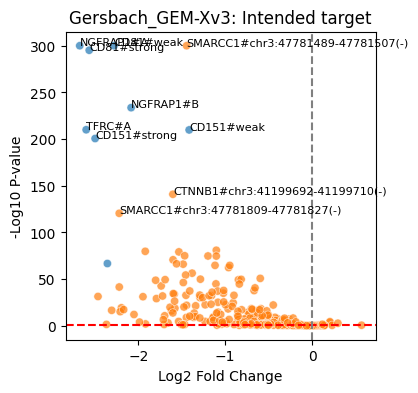

In [9]:
# Make a volcano plot of perturb_log2_fc vs -log10(perturbo_p_value), color by label
# Label the top 10 guides by -log10(perturbo_p_value)
cis_res_guide_intended["label"] = cis_res_guide_intended["label"].astype(str)
plot_data = cis_res_guide_intended.copy()
plot_data = plot_data.dropna(subset=["perturbo_log2_fc", "perturbo_p_value"])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=plot_data, x="perturbo_log2_fc", y=-np.log10(plot_data["perturbo_p_value"] + 1e-300), hue="label", alpha=0.7)
top10 = plot_data.nsmallest(10, "perturbo_p_value")
for _, row in top10.iterrows():
    print(row["guide_id"], row["perturbo_log2_fc"], row["perturbo_p_value"])
    plt.text(row["perturbo_log2_fc"], -np.log10(row["perturbo_p_value"] + 1e-300), row["guide_id"], fontsize=8)
plt.title(f"{lab}: Intended target")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value")
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
#plt.legend(title="Label", loc="center left")
# remove legend
plt.legend([],[], frameon=False)
#plt.tight_layout()

# Save plot
plt.savefig(os.path.join(path_out, f"{dataset}_perturbo-cis-intended-target_volcano.png"), dpi=300)
plot_data[["guide_id", "gene_name", "perturbo_log2_fc", "perturbo_p_value"]].rename(columns={
    "perturbo_log2_fc": "log2_fc",
    "perturbo_p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-cis-intended-target_results.tsv"), index=False, sep="\t")

In [10]:
num_tests = cis_res_guide_intended.shape[0]

# How many had a 60% knockdown or more?
fc_threshold = 0.4
log2fc_threshold = np.log2(fc_threshold)
strong_knockdowns = cis_res_guide_intended[cis_res_guide_intended["perturbo_log2_fc"] <= log2fc_threshold]
num_strong_knockdowns = len(strong_knockdowns)
print(f"Number of guides with at least {int((1-fc_threshold)*100)}% knockdown: {num_strong_knockdowns} out of {num_tests} tests ({num_strong_knockdowns/num_tests*100:.2f}%)")
strong_knockdowns[["guide_id", "gene_name", "perturbo_log2_fc", "perturbo_p_value"]].rename(columns={
    "perturbo_log2_fc": "log2_fc",
    "perturbo_p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-cis-intended-target_strong-knockdowns-fc-{fc_threshold}.tsv"), index=False, sep="\t")

# How many are downregulated significant at 0.05 level?
pval_threshold = 0.05
significant = cis_res_guide_intended[(cis_res_guide_intended["perturbo_p_value"] < pval_threshold) & (cis_res_guide_intended["perturbo_log2_fc"] < 0)]
num_significant = len(significant)
print(f"Number of guides significant at p<{pval_threshold}: {num_significant} out of {num_tests} tests ({num_significant/num_tests*100:.2f}%)")
significant[["guide_id", "gene_name", "perturbo_log2_fc", "perturbo_p_value"]].rename(columns={
    "perturbo_log2_fc": "log2_fc",
    "perturbo_p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-cis-intended-target_significant-pval-{pval_threshold}.tsv"), index=False, sep="\t")

Number of guides with at least 60% knockdown: 61 out of 416 tests (14.66%)
Number of guides significant at p<0.05: 191 out of 416 tests (45.91%)


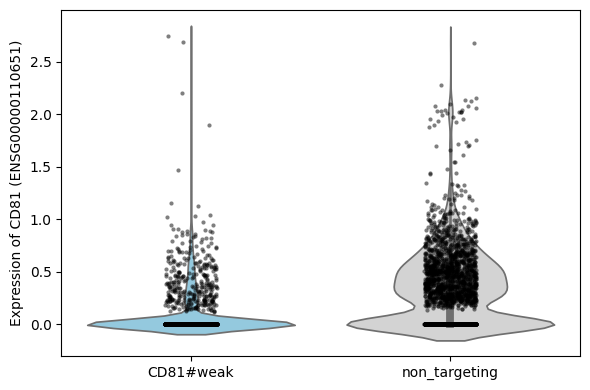

In [12]:
ind = 0
sorted_res = cis_res_guide_intended.sort_values("perturbo_p_value")
guide_id = sorted_res.iloc[ind]["guide_id"]
target_id = sorted_res.iloc[ind]["intended_target_name"]
gene_name = id_map[target_id]

expr_df = get_target_vs_nontarget_expr(
    mdata,
    guide_id=guide_id,
    gene_id=target_id,
)

# Plot and color non-targeting vs targeting differently
plt.figure(figsize=(6, 4))
sns.violinplot(data=expr_df, x="group", y="expression", hue="group", palette={"non_targeting": "lightgrey", guide_id: "skyblue"})
sns.stripplot(data=expr_df, x="group", y="expression", color="k", size=3, alpha=0.5)
plt.ylabel(f"Expression of {gene_name} ({target_id})")
plt.xlabel(f"")
plt.tight_layout()

# Trans analysis

## Intended targets only

In [13]:
# Load res at guide level
trans_res_guide = mdata.uns["trans_per_guide_results"]

# Add in intended target gene name
trans_res_guide["gene_name"] = trans_res_guide["gene_id"].map(id_map)

# add target name from guide_id
trans_res_guide["target_name"] = trans_res_guide["guide_id"].str.split("#").str[0]

# Keep only those with gene_name and target_name same
trans_res_guide_intended = trans_res_guide[trans_res_guide["gene_name"] == trans_res_guide["target_name"]]

# Deduplicate
trans_res_guide_intended = trans_res_guide_intended.drop_duplicates(subset=["guide_id", "gene_id"])

# Merge in guide metadata
trans_res_guide_intended = guide_meta.merge(trans_res_guide_intended[["guide_id", "log2_fc", "p_value"]], left_on="guide_id", right_on="guide_id", how="left")

# Head
trans_res_guide_intended.head()

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,pam,genomic_element,...,intended_target_chr,intended_target_start,intended_target_end,putative_target_genes,reporter,imperfect,gene_name,label,log2_fc,p_value
0,CD81#strong,GAGAGCGAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,...,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control,-2.542787,1.000561e-212
1,CD81#weak,GAGAGCCAGCGCGCAACGG,True,positive control,chr11,2377315.0,2377333.0,+,NGG,promoter,...,chr11,2377315.0,2377333.0,NaN,NaN,NaN,CD81,positive_control,-2.236973,0.000000e+00
2,CD151#strong,CCGGACTCGGACGCGTGGT,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,...,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control,-2.513763,9.306537e-248
3,CD151#weak,CCGCTCGGCCGAGCTGTCG,True,positive control,chr11,833006.0,833024.0,+,NGG,promoter,...,chr11,833006.0,833024.0,NaN,NaN,NaN,CD151,positive_control,-1.424966,4.642992e-171
4,CD55#strong,CTGCGACTCGGCGGAGTCC,True,positive control,chr1,207321714.0,207321732.0,+,NGG,promoter,...,chr1,207321714.0,207321732.0,NaN,NaN,NaN,CD55,positive_control,-2.348905,2.189833e-138


CD81#weak -2.2369726 0.0
NGFRAP1#B -2.0953815 0.0
NGFRAP1#A -2.6841598 0.0
TFRC#A -2.6191063 4.9591030101210206e-290
CD151#strong -2.5137627 9.306536870327728e-248
SMARCC1#chr3:47781809-47781827(-) -2.2334208 1.5134304160094639e-237
SMARCC1#chr3:47781489-47781507(-) -1.4532887 5.642625215084874e-219
CD81#strong -2.5427868 1.0005609032359644e-212
CD151#weak -1.424966 4.642991611542058e-171
CD55#strong -2.3489048 2.1898333085803632e-138


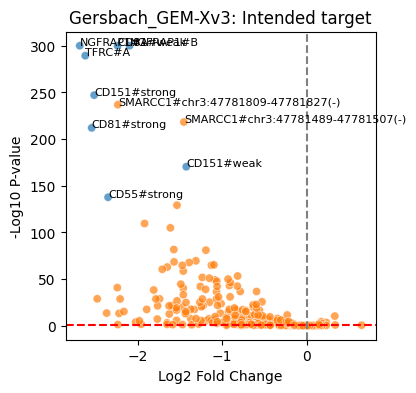

In [14]:
# Make a volcano plot of perturb_log2_fc vs -log10(p_value), color by label
# Label the top 10 guides by -log10(p_value)
trans_res_guide_intended["label"] = trans_res_guide_intended["label"].astype(str)
plot_data = trans_res_guide_intended.copy()
plot_data = plot_data.dropna(subset=["log2_fc", "p_value"])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=plot_data, x="log2_fc", y=-np.log10(plot_data["p_value"] + 1e-300), hue="label", alpha=0.7)
top10 = plot_data.nsmallest(10, "p_value")
for _, row in top10.iterrows():
    print(row["guide_id"], row["log2_fc"], row["p_value"])
    plt.text(row["log2_fc"], -np.log10(row["p_value"] + 1e-300), row["guide_id"], fontsize=8)
plt.title(f"{lab}: Intended target")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value")
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
#plt.legend(title="Label")
plt.legend([],[], frameon=False)

#plt.tight_layout()

# Save plot
plt.savefig(os.path.join(path_out, f"{dataset}_perturbo-trans-intended-target_volcano.png"), dpi=300)
plot_data[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-trans-intended-target_results.tsv"), index=False, sep="\t")

In [15]:
num_tests = trans_res_guide_intended.shape[0]

In [16]:
# Save strong knockdowns
fc_threshold = 0.4
log2fc_threshold = np.log2(fc_threshold)
strong_knockdowns = trans_res_guide_intended[trans_res_guide_intended["log2_fc"] <= log2fc_threshold]
num_strong_knockdowns = len(strong_knockdowns)
print(f"Number of guides with at least {int((1-fc_threshold)*100)}% knockdown: {num_strong_knockdowns} out of {num_tests} tests ({num_strong_knockdowns/num_tests*100:.2f}%)")
strong_knockdowns[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-trans-intended-target_strong_knockdowns.tsv"), index=False, sep="\t")

# How many where significant at 0.05 level?
pval_threshold = 0.05
significant = trans_res_guide_intended[trans_res_guide_intended["p_value"] < pval_threshold]
num_significant = len(significant)
print(f"Number of guides significant at p<{pval_threshold}: {num_significant} out of {num_tests} tests ({num_significant/num_tests*100:.2f}%)")
significant[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-trans-intended-target_significant.tsv"), index=False, sep="\t")

Number of guides with at least 60% knockdown: 60 out of 416 tests (14.42%)
Number of guides significant at p<0.05: 198 out of 416 tests (47.60%)


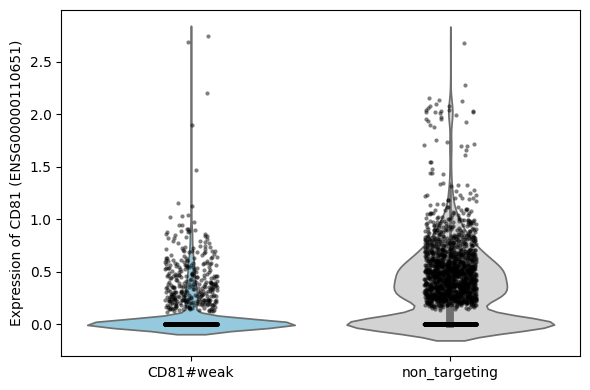

In [17]:
ind = 0
sorted_res = trans_res_guide_intended.sort_values("p_value")
guide_id = sorted_res.iloc[ind]["guide_id"]
target_id = sorted_res.iloc[ind]["intended_target_name"]
gene_name = id_map[target_id]

expr_df = get_target_vs_nontarget_expr(
    mdata,
    guide_id=guide_id,
    gene_id=target_id,
)

# Plot and color non-targeting vs targeting differently
plt.figure(figsize=(6, 4))
sns.violinplot(data=expr_df, x="group", y="expression", hue="group", palette={"non_targeting": "lightgrey", guide_id: "skyblue"})
sns.stripplot(data=expr_df, x="group", y="expression", color="k", size=3, alpha=0.5)
plt.ylabel(f"Expression of {gene_name} ({target_id})")
plt.xlabel(f"")
plt.tight_layout()

## Trans effects

In [53]:
# Deduplicate
trans_res_guide = trans_res_guide.drop_duplicates(subset=["guide_id", "gene_id"])

# Merge in guide metadata
trans_res_guide = guide_meta.merge(trans_res_guide[["guide_id", "log2_fc", "p_value"]], left_on="guide_id", right_on="guide_id", how="left")

# Head
trans_res_guide.head()

,guide_id,spacer,targeting,type,guide_chr,guide_start,guide_end,strand,PAM,intended_target_name,intended_target_chr,intended_target_start,intended_target_end,gene_name,label,log2_fc,p_value
0,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,0.017092,0.729835
1,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,0.111755,0.076803
2,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,-0.026427,0.614363
3,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,0.098865,0.005546
4,CD81#weak,CCGTTGCGCGCTGGCTCTC,True,targeting,chr11,2377315.0,2377333.0,+,NGG,ENSG00000110651,chr11,2377315.0,2377333.0,CD81,positive_control,0.053253,0.199783


CD81#weak -2.0226414 0.0
NGFRAP1#A -2.0817137 0.0
HIF1A#chr14:61695605-61695623(-) -1.4757324 0.0
REST#chr4:56907913-56907931(+) 3.8237746 0.0
REST#chr4:56907913-56907931(+) 3.892902 1.1720169351281202e-279
HIF1A#chr14:61695530-61695548(-) -1.8736569 2.982946075855868e-273
CTNNB1#chr3:41199530-41199548(+) 4.2089243 1.1996286022465605e-252
CTNNB1#chr3:41199530-41199548(+) -1.7202677 7.094855719007844e-238
CTNNB1#chr3:41199530-41199548(+) 3.3938503 1.1666083582416803e-205
SUZ12#chr17:31937142-31937160(-) 3.2155633 3.661143849868938e-205


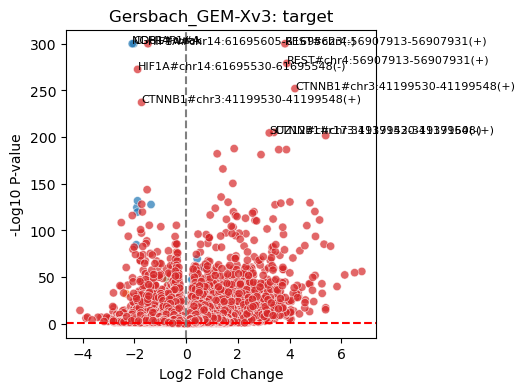

In [54]:
# Make a volcano plot of perturb_log2_fc vs -log10(p_value), color by label
# Label the top 10 guides by -log10(p_value)
trans_res_guide["label"] = trans_res_guide["label"].astype(str)
plot_data = trans_res_guide.copy()
plot_data = plot_data.dropna(subset=["log2_fc", "p_value"])

plt.figure(figsize=(4, 4))
sns.scatterplot(data=plot_data, x="log2_fc", y=-np.log10(plot_data["p_value"] + 1e-300), hue="label", alpha=0.7)

plt.title(f"{lab}: target")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 P-value")
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.legend(title="Label")

#plt.tight_layout()

In [ ]:
# Save plot
plt.savefig(os.path.join(path_out, f"{dataset}_perturbo-trans-target_volcano.png"), dpi=300)
plot_data[["guide_id", "gene_name", "log2_fc", "p_value"]].rename(columns={
    "log2_fc": "log2_fc",
    "p_value": "p_value",
}).to_csv(os.path.join(path_out, f"{dataset}_perturbo-trans-target_results.tsv"), index=False, sep="\t")

# DONE!

---
